In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py

In [3]:
df = pd.read_csv("datosCabaYGBA.csv",low_memory = False)

In [4]:
df.drop("Unnamed: 0",axis=1,inplace=True)

# Analizamos la evolucion del precio de una propiedad alrededor de la estacion de subte Las Heras, a traves del tiempo, tener en cuenta que se inauguró en diciembre de 2015

In [5]:

propsCapital = df[df["place_with_parent_names"].str.contains("Capital Federal")]


In [6]:
propsCapital = propsCapital.dropna(subset = ["lat-lon"])

In [7]:
propsCapital = propsCapital[propsCapital["place_name"] != "Capital Federal"] #No es un barrio de CABA

In [8]:
propsCapital = propsCapital[["property_type","created_on",\
                             "lat-lon","place_name","price_aprox_usd",\
                             "price_usd_per_m2","surface_total_in_m2"]]

In [9]:
propsRecoleta = propsCapital[propsCapital["place_name"] == "Recoleta"]

# Me quedo con propiedades con superficie total dentro de un determinado rango

In [10]:
from utils_analisis import latLonToInt,calcular_distancia
estacionLH = (-34.588203, -58.398268)


In [11]:
propsRecoleta["DistEstacionLH"] = propsRecoleta.apply(lambda row: calcular_distancia(latLonToInt(row["lat-lon"]),estacionLH),axis=1)

/home/tomas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [12]:
#Me quedo con las propiedades que estan en unradio de 600 metros de la stacion LH y con un tamaño dentro del promedio
cercanas = propsRecoleta[propsRecoleta["DistEstacionLH"] <= 0.8 ]
cercanas = cercanas[cercanas["price_aprox_usd"] > 0]
promSupTotal = cercanas["surface_total_in_m2"].mean()
cercanas = cercanas[(cercanas["surface_total_in_m2"] < promSupTotal + 20 ) & (cercanas["surface_total_in_m2"] > promSupTotal - 20 )]

In [13]:
cercanas["YearMonthCreation"] = cercanas.apply(lambda row:\
                                "-".join(row["created_on"].split("-")[:2]),axis=1)

In [14]:
#La propiedad con index 174462 tiene un precio por m2 muy extraño en comparacion a otras. Lo elimino

In [15]:
grouped = cercanas.loc[:,['YearMonthCreation','price_aprox_usd']].groupby('YearMonthCreation').\
    agg([np.mean])

In [16]:
grouped.index.rename("Año - mes",inplace= True)


# Estudio que pasa en tiempos cercanos a la inauguracion del subte

In [17]:
import matplotlib.dates as mdates

In [18]:
grouped = grouped.loc[(grouped.index < '2017-09') & (grouped.index > '2015-10')]

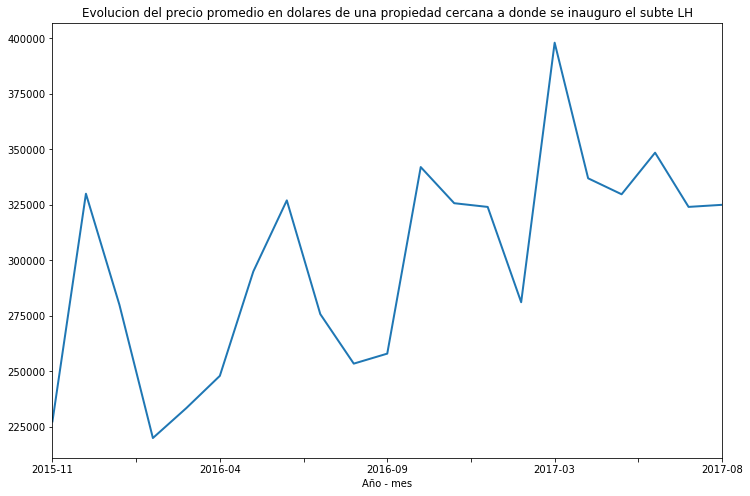

In [19]:

grouped.plot(linewidth=2,figsize=(12,8),legend=False,title="Evolucion del precio promedio en dolares de una propiedad cercana a donde se inauguro el subte LH")

In [20]:
plt.show()

# Se observa un incremento del precio de las propiedades en general a lo largo del tiempo luego de la inauguracion del subte

# A continuacion se calcula la distancia de cualquier propiedad hasta el primer medio de transporte que puede ser el tren o el subte

In [21]:
from pos_subtes_y_trenes_capital import medios_transporte

In [22]:
propsCapital = propsCapital[propsCapital["price_aprox_usd"] > 0]

In [23]:
propsCapital["distMinTransporte"] = propsCapital.apply(lambda row: min(calcular_distancia(latLonToInt(row["lat-lon"]),x) for x in medios_transporte),axis=1)

In [24]:
propsCapRango5kmTransporte = propsCapital[propsCapital["distMinTransporte"] < 5]

# En los ultimos 3 años, que podemos observar de esto?

In [25]:
propsCapUltimosAnhos = propsCapRango5kmTransporte[propsCapRango5kmTransporte["created_on"].str.contains("2015") |\
                                                 propsCapRango5kmTransporte["created_on"].str.contains("2016") |\
                                                 propsCapRango5kmTransporte["created_on"].str.contains("2017")]

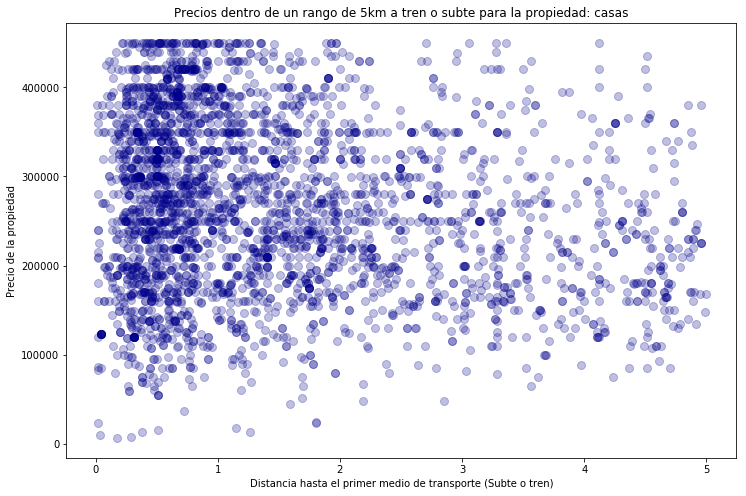

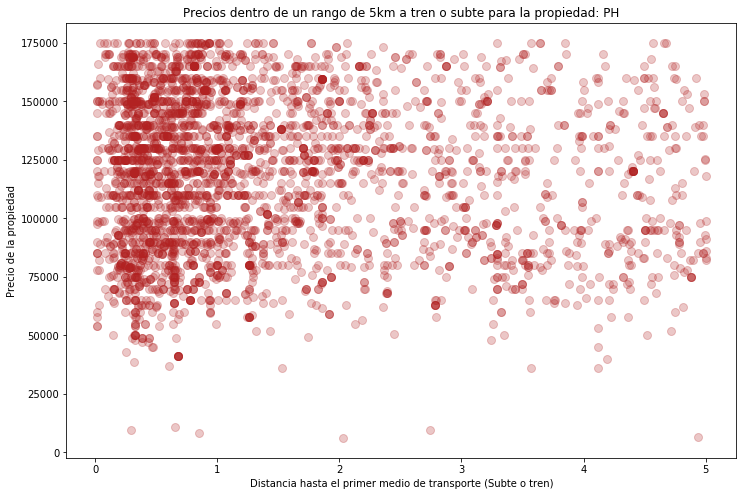

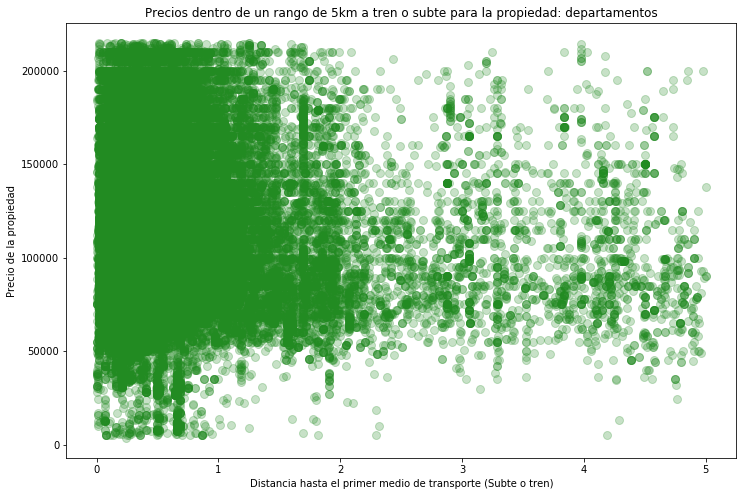

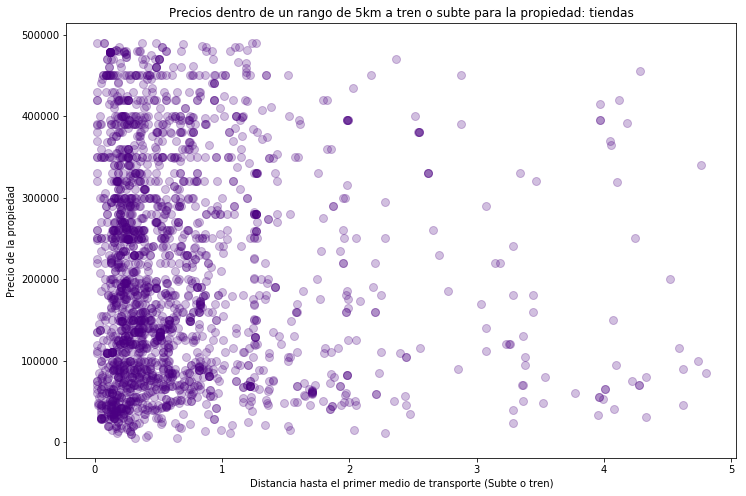

In [26]:
tiposPropiedades = {"apartment":("forestgreen","departamentos"),"house":("darkblue","casas"),\
            "store":("indigo","tiendas"),"PH":("firebrick","PH")}

for prop in tiposPropiedades:
    fig, ax = plt.subplots(figsize=(12,8))
    props = propsCapUltimosAnhos[propsCapUltimosAnhos["property_type"] == prop]
    props = props[props["price_aprox_usd"] < props["price_aprox_usd"].mean() + 500.000]
    ax.plot(props.distMinTransporte, props.price_aprox_usd,marker="o", \
            linestyle='', ms=8,color=tiposPropiedades[prop][0], label=prop, alpha= 0.25)
    plt.title("Precios dentro de un rango de 5km a tren o subte para la propiedad: "+tiposPropiedades[prop][1])
    plt.xlabel("Distancia hasta el primer medio de transporte (Subte o tren)")
    plt.ylabel("Precio de la propiedad")
    plt.show()

### Conclusiones:
#### 1) Se puede ver que mientras mas lejos se esta de los principales medios de transporte, habrán menos publicaciones de ventas de propiedades. Esto se manifiesta mas que nada para las ventas del tipo tiendas, lo cual tiene mucho sentido ya que las zonas mas cercanas a estos dos medios de transporte suelen tener mucho movimiento y por ende zonas de comercio.
#### 2) A medida que me alejo, la cantidad de propiedades con precios altos comienza a decrecer. En los departamentos esto se nota con más claridad

# ¿El precio promedio de una propiedad vale más si está en una esquina? 

In [27]:
#Analizo esto en una muestra de las propiedades con un precio no muy distante del promedio

In [28]:
df["description"] = df["description"].str.lower()
df["extra"] = df["extra"].str.lower()
df["title"] = df["title"].str.lower()

In [29]:
df["Zona"] = df.apply(lambda row: row["place_with_parent_names"].split("|")[2],axis=1)

In [30]:
props_con_precio_cercano_promedio = df[(df["price_aprox_usd"] < (df["price_aprox_usd"].mean() + 130000)) &\
                                      (df["price_aprox_usd"] > (df["price_aprox_usd"].mean() - 130000))]

In [31]:
titlEsquina = props_con_precio_cercano_promedio["title"].str.contains("esquina").fillna(False)
extraEsquina = props_con_precio_cercano_promedio["extra"].str.contains("esquina").fillna(False)
descEsquina = props_con_precio_cercano_promedio["description"].str.contains("esquina").fillna(False)

In [32]:
propsEsquina = props_con_precio_cercano_promedio[titlEsquina | extraEsquina | descEsquina]

In [33]:
propsRestantes = props_con_precio_cercano_promedio[~titlEsquina & ~extraEsquina & ~descEsquina]

In [34]:
data_esquinas_zona = []
zonas = ["Capital Federal", "Bs.As. G.B.A. Zona Norte", "Bs.As. G.B.A. Zona Sur", "Bs.As. G.B.A. Zona Oeste"]
for zona in zonas: #Las 4 zonas que estudiamos
    info_zona = {}
    promedio_esquinas = propsEsquina[propsEsquina["Zona"] == zona]["price_aprox_usd"].mean()
    promedio_entre_esquinas = propsRestantes[propsRestantes["Zona"] == zona]["price_aprox_usd"].mean()
    info_zona["Zona"] = zona
    info_zona["Precio promedio esquinas"] = promedio_esquinas
    info_zona["Precio promedio entre esquinas"] = promedio_entre_esquinas
    data_esquinas_zona.append(info_zona)

In [35]:
esquinas = pd.DataFrame(data_esquinas_zona)
esquinas["Zona"] = esquinas["Zona"].str.replace("Capital Federal","CABA")
esquinas["Zona"] = esquinas["Zona"].str.replace("Bs.As. G.B.A. Zona Norte","Zona Norte")
esquinas["Zona"] = esquinas["Zona"].str.replace("Bs.As. G.B.A. Zona Sur","Zona Sur")
esquinas["Zona"] = esquinas["Zona"].str.replace("Bs.As. G.B.A. Zona Oeste","Zona Oeste")
esquinas.index = esquinas.Zona

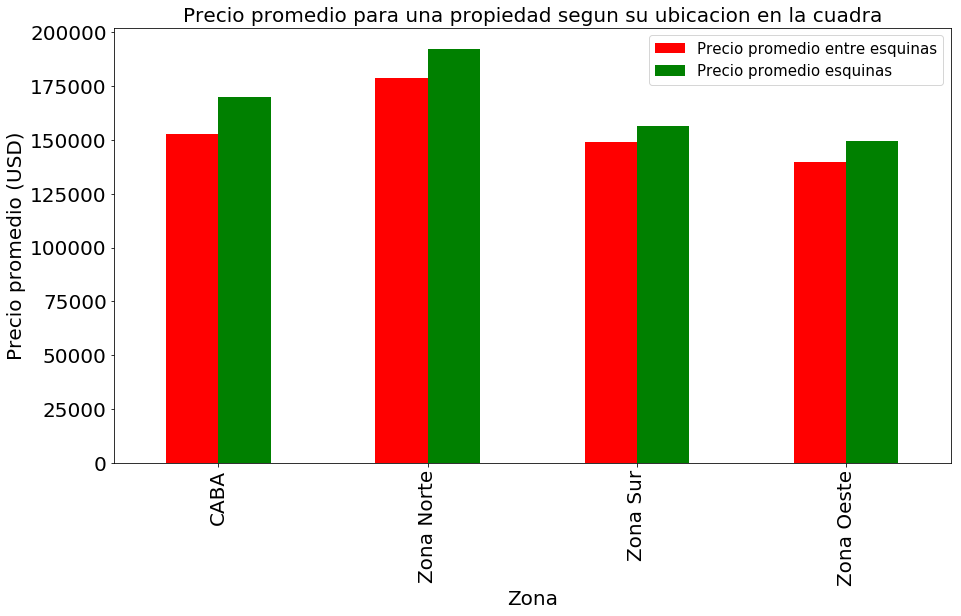

In [36]:
ax = esquinas.plot(kind = "bar", color =["r","g"] ,fontsize=20,figsize = (15,8))
ax.set_xlabel("Zona", fontsize=20)
ax.set_ylabel("Precio promedio (USD)", fontsize=20)
ax.set_title('Precio promedio para una propiedad segun su ubicacion en la cuadra', fontsize = 20)
ax.legend(fontsize = 15)

### Conclusiones:
#### Se ve que dentro de las propiedades que estan en el rango de precio promedio, las que se encuentran ubicadas en una esquina tienen un precio promedio mayor a las que se encuentran entre esquinas. Esto debe ser por las distintas ventajas que tiene una propiedad ubicada en una esquina (Acceso por dos calles distintas, vista, etc..)


In [37]:
df.corr()

,floor,geonames_id,price_aprox_usd,price_usd_per_m2,rooms,surface_covered_in_m2,surface_total_in_m2
floor,1.000000,-0.008883,0.058442,0.012059,-0.022105,0.021520,-0.002190
geonames_id,-0.008883,1.000000,-0.020933,-0.001040,-0.017763,-0.002139,-0.009442
price_aprox_usd,0.058442,-0.020933,1.000000,0.030036,0.349040,0.073240,0.211114
price_usd_per_m2,0.012059,-0.001040,0.030036,1.000000,-0.002995,-0.002423,-0.007519
rooms,-0.022105,-0.017763,0.349040,-0.002995,1.000000,0.016310,0.100318
surface_covered_in_m2,0.021520,-0.002139,0.073240,-0.002423,0.016310,1.000000,0.245155
surface_total_in_m2,-0.002190,-0.009442,0.211114,-0.007519,0.100318,0.245155,1.000000


### Segun las interpretaciones del coeficientes de correlacion definidas en http://www.dmstat1.com/res/TheCorrelationCoefficientDefined.html
#### De esta tabla de correlaciones se podria decir que el precio aproximado de una propiedad esta moderadamente relacionado con la cantidad de ambientes que posee (Su coeficiente de correlacion es 0.34). Esto quiere decir que, a medida que aumenta la cantidad de habitaciones de una propiedad, se veria, aunque de una forma difusa, como aumenta el precio de la propiedad
#### El segundo valor más alto es la correlacion entre la superficie total en m2 y el precio aproximado en usd. En este caso el factor de correlacion es 0.21, es aun mas difuso que el resultado mencionado anteriormente, pero es positivo. 

In [38]:
#asd = df[props_con_precio_cercano_promedio["title"].str.contains("a estrenar").fillna(False) | props_con_precio_cercano_promedio["extra"].str.contains("a estrenar").fillna(False) | props_con_precio_cercano_promedio["description"].str.contains("a estrenar").fillna(False)]
#bad = df[~props_con_precio_cercano_promedio["title"].str.contains("a estrenar").fillna(False) & ~props_con_precio_cercano_promedio["description"].str.contains("a estrenar").fillna(False) & ~props_con_precio_cercano_promedio["description"].str.contains("a estrenar").fillna(False)]

In [39]:
props_sup_precio_similar = props_con_precio_cercano_promedio\
                        [(props_con_precio_cercano_promedio["surface_total_in_m2"] <\
                        props_con_precio_cercano_promedio["surface_total_in_m2"].mean() + 30) &\
                        (props_con_precio_cercano_promedio["surface_total_in_m2"] >\
                        props_con_precio_cercano_promedio["surface_total_in_m2"].mean() - 30)] 

In [40]:
titleAEstrenar = props_sup_precio_similar["title"].str.contains("a estrenar").fillna(False)
descAEstrenar = props_sup_precio_similar["description"].str.contains("a estrenar").fillna(False)
extraAEstrenar = props_sup_precio_similar["extra"].str.contains("a estrenar").fillna(False)


In [41]:
propsAEstrenar = props_sup_precio_similar[titleAEstrenar | descAEstrenar | extraAEstrenar]                                                

In [42]:
propsViejas = props_sup_precio_similar[~titleAEstrenar & ~extraAEstrenar & ~descAEstrenar]

In [43]:
#propsAEstrenar = _propsAEstrenar[_propsAEstrenar["property_type"] == "store"]
#propsViejas = _propsViejas[_propsViejas["property_type"] == "store"]

In [44]:
data_antiguedad_props = []
zonas = ["Capital Federal", "Bs.As. G.B.A. Zona Norte", "Bs.As. G.B.A. Zona Sur", "Bs.As. G.B.A. Zona Oeste"]
tipos = ["apartment", "house", "store", "PH"]
for zona in zonas: #Las 4 zonas que estudiamos
    info_zona = {}
    for tipo_prop in tipos:
        
        promedio_viejas = propsViejas[(propsViejas["Zona"] == zona) &\
                                      (propsViejas["property_type"] == tipo_prop)]["price_aprox_usd"].mean()
        promedio_nuevas = propsAEstrenar[(propsAEstrenar["Zona"] == zona) &\
                                         (propsAEstrenar["property_type"] == tipo_prop)]["price_aprox_usd"].mean()
        info_zona["Zona"] = zona
        info_zona[tipo_prop+" a estrenar"] = promedio_nuevas
        info_zona[tipo_prop+" vieja"] = promedio_viejas
    data_antiguedad_props.append(info_zona)

In [45]:
antiguedadPropsdf = pd.DataFrame(data_antiguedad_props)
antiguedadPropsdf

,PH a estrenar,PH vieja,Zona,apartment a estrenar,apartment vieja,house a estrenar,house vieja,store a estrenar,store vieja
0,189473.540541,173919.558453,Capital Federal,231052.358397,231456.848055,207166.666667,193381.851732,251203.488947,223702.281146
1,175588.555323,152309.427497,Bs.As. G.B.A. Zona Norte,231353.813791,223750.764649,189909.131670,182410.576214,230000.000000,210875.407000
2,100251.538000,124808.500000,Bs.As. G.B.A. Zona Sur,209754.641489,190083.178118,195142.459231,162723.794410,NaN,151269.696970
3,124463.414634,118424.831324,Bs.As. G.B.A. Zona Oeste,173871.574808,150632.086815,145968.261019,148922.788776,125000.000000,128533.333333


In [46]:

antiguedadPropsdf["Zona"] = antiguedadPropsdf["Zona"].str.replace("Capital Federal","CABA")
antiguedadPropsdf["Zona"] = antiguedadPropsdf["Zona"].str.replace("Bs.As. G.B.A. Zona Norte","Zona Norte")
antiguedadPropsdf["Zona"] = antiguedadPropsdf["Zona"].str.replace("Bs.As. G.B.A. Zona Sur","Zona Sur")
antiguedadPropsdf["Zona"] = antiguedadPropsdf["Zona"].str.replace("Bs.As. G.B.A. Zona Oeste","Zona Oeste")
antiguedadPropsdf.index = antiguedadPropsdf.Zona

In [47]:
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
#legend([plot1], "title", prop = fontP)

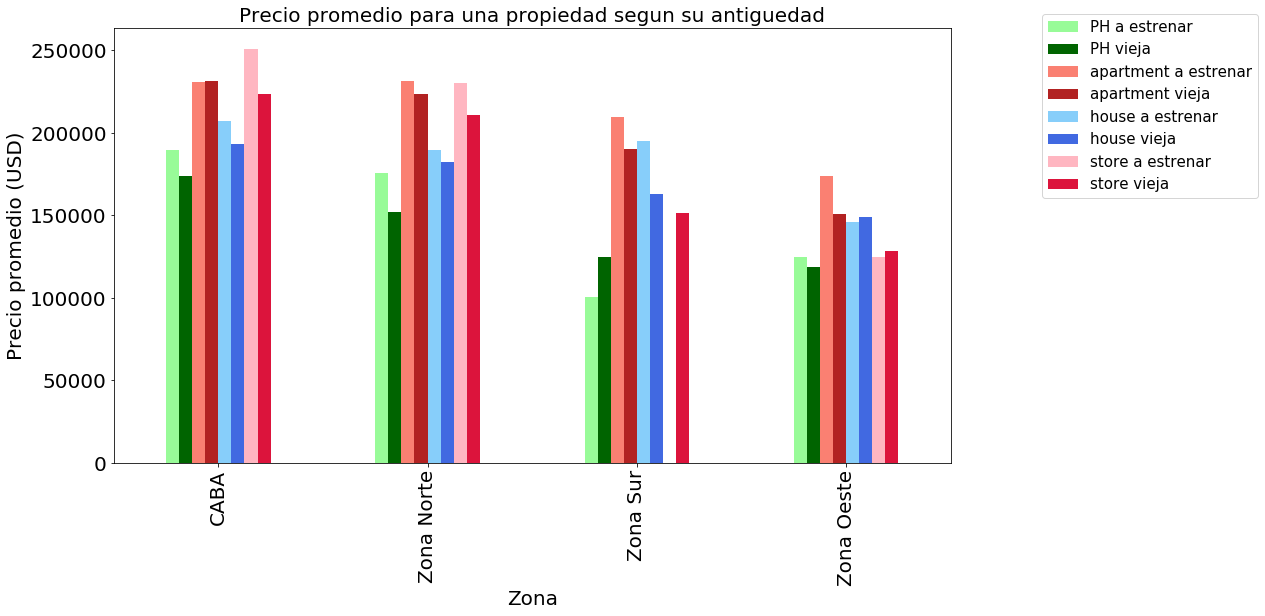

In [48]:


ax = antiguedadPropsdf.plot(kind = "bar",\
                            color =["palegreen","darkgreen","salmon","firebrick","lightskyblue","royalblue","lightpink","crimson"] ,\
                            fontsize=20,figsize = (15,8))
ax.set_xlabel("Zona", fontsize=20)
ax.set_ylabel("Precio promedio (USD)", fontsize=20)
ax.set_title('Precio promedio para una propiedad segun su antiguedad', fontsize = 20)
ax.legend(bbox_to_anchor=(1.1, 1.05), fontsize = 15)



## Conclusiones:

In [51]:
import folium

In [52]:
map_osm = folium.Map(location=[-34.556272, -58.465813])

In [53]:
orden_mas_caras = props_sup_precio_similar.sort_values("price_aprox_usd", axis = 0, ascending = True)
orden_mas_caras.dropna(subset=["lat-lon"],inplace=True)

In [56]:
top_1000_mas_caras = orden_mas_caras.head(1000)

In [58]:

for index, row in top_1000_mas_caras.iterrows():
    folium.CircleMarker(location=(latLonToInt(row["lat-lon"])[0],latLonToInt(row["lat-lon"])[1])).add_to(map_osm)
map_osm